In [1]:
# Import Libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
# Read in the data
df = pd.read_csv('https://github.com/doski-codes/bpnn-ngsim-congestion/blob/master/NGSIM_US101.csv?raw=true')

In [3]:
df.head()

,Unnamed: 0,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway,Congestion
0,0,515,2330.0,1123.0,1.118848e+12,30.034,188.062,6451203.729,1873252.549,13.0,6.9,2.0,23.31,2.05,3.0,500.0,523.0,119.10,5.11,0
1,1,515,2330.0,1123.0,1.118848e+12,30.034,188.062,6451203.729,1873252.549,13.0,6.9,2.0,23.31,2.05,3.0,500.0,523.0,119.10,5.11,0
2,3,2127,6459.0,567.0,1.118848e+12,19.632,1775.614,6452425.122,1872172.475,13.5,6.9,2.0,37.52,11.20,2.0,2124.0,2132.0,48.92,1.30,0
3,4,1033,4827.0,592.0,1.118848e+12,6.202,1701.144,6452347.673,1872258.452,13.5,4.4,2.0,41.99,0.10,1.0,1029.0,1040.0,38.81,0.92,0
4,5,1033,4827.0,592.0,1.118848e+12,6.202,1701.144,6452347.673,1872258.452,13.5,4.4,2.0,41.99,0.10,1.0,1029.0,1040.0,38.81,0.92,0


In [4]:
df.drop(columns=['Unnamed: 0', 'Congestion'], inplace=True)

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.describe()

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway
count,455846.000000,455846.000000,455846.000000,4.558460e+05,455846.000000,455846.000000,4.558460e+05,4.558460e+05,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000
mean,1335.086031,5296.503345,739.689195,1.118848e+12,29.741326,1043.131800,6.451849e+06,1.872668e+06,15.309449,6.296412,2.016080,30.119328,0.159670,2.991453,1272.369618,1276.829528,67.275576,191.713501
std,788.495635,2664.308538,204.465991,7.693255e+05,16.588804,603.410021,4.511053e+02,4.008011e+02,4.488224,0.892994,0.162736,14.070791,4.550935,1.459117,815.509491,817.265165,41.049844,1360.754989
min,1.000000,10.000000,160.000000,1.118847e+12,0.369000,3.051000,6.451067e+06,1.871889e+06,4.000000,2.000000,1.000000,0.000000,-11.200000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,668.000000,2981.000000,568.000000,1.118848e+12,17.607000,521.866000,6.451455e+06,1.872329e+06,13.500000,5.900000,2.000000,20.000000,-0.770000,2.000000,571.000000,574.000000,43.430000,1.670000
50%,1321.000000,5535.000000,738.000000,1.118849e+12,29.780000,1003.489500,6.451817e+06,1.872690e+06,15.000000,6.400000,2.000000,30.240000,0.000000,3.000000,1259.000000,1262.000000,59.660000,2.280000
75%,1901.000000,7645.000000,904.000000,1.118849e+12,41.767750,1553.459000,6.452230e+06,1.873010e+06,16.000000,6.900000,2.000000,39.990000,1.380000,4.000000,1868.000000,1873.000000,82.580000,3.190000
max,3109.000000,10000.000000,1328.000000,1.118850e+12,75.682000,2217.411000,6.452733e+06,1.873401e+06,76.100000,8.500000,3.000000,95.300000,11.200000,8.000000,3109.000000,3109.000000,771.160000,9999.990000


In [7]:
df['Global_Time'] = pd.to_datetime(df['Global_Time'], unit='ms').dt.tz_localize('GMT').dt.tz_convert('US/Pacific')

In [8]:
df['Hours'] = df.Global_Time.dt.hour / 24
df['Minutes'] = df.Global_Time.dt.minute / 60

In [9]:
df.head()

,Vehicle_ID,Frame_ID,Total_Frames,Global_Time,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway,Hours,Minutes
0,515,2330.0,1123.0,2005-06-15 08:07:55-07:00,30.034,188.062,6451203.729,1873252.549,13.0,6.9,2.0,23.31,2.05,3.0,500.0,523.0,119.10,5.11,0.333333,0.116667
2,2127,6459.0,567.0,2005-06-15 08:00:24.800000-07:00,19.632,1775.614,6452425.122,1872172.475,13.5,6.9,2.0,37.52,11.20,2.0,2124.0,2132.0,48.92,1.30,0.333333,0.000000
3,1033,4827.0,592.0,2005-06-15 08:12:04.700000-07:00,6.202,1701.144,6452347.673,1872258.452,13.5,4.4,2.0,41.99,0.10,1.0,1029.0,1040.0,38.81,0.92,0.333333,0.200000
5,1890,9157.0,628.0,2005-06-15 08:34:32.700000-07:00,53.514,817.521,6451655.238,1872800.663,24.0,8.5,3.0,45.12,-0.55,5.0,1882.0,1897.0,102.65,2.27,0.333333,0.566667
6,744,3392.0,996.0,2005-06-15 08:09:41.200000-07:00,28.878,490.086,6451422.353,1873041.018,15.0,5.9,2.0,24.54,-0.04,3.0,740.0,752.0,37.80,1.54,0.333333,0.150000


In [10]:
global_time = df.Global_Time

In [11]:
df.drop(columns='Global_Time', inplace=True)

In [12]:
data = df.iloc[:, 2:]

In [13]:
data.reset_index(inplace=True, drop=True)

In [14]:
data.head()

,Total_Frames,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway,Hours,Minutes
0,1123.0,30.034,188.062,6451203.729,1873252.549,13.0,6.9,2.0,23.31,2.05,3.0,500.0,523.0,119.10,5.11,0.333333,0.116667
1,567.0,19.632,1775.614,6452425.122,1872172.475,13.5,6.9,2.0,37.52,11.20,2.0,2124.0,2132.0,48.92,1.30,0.333333,0.000000
2,592.0,6.202,1701.144,6452347.673,1872258.452,13.5,4.4,2.0,41.99,0.10,1.0,1029.0,1040.0,38.81,0.92,0.333333,0.200000
3,628.0,53.514,817.521,6451655.238,1872800.663,24.0,8.5,3.0,45.12,-0.55,5.0,1882.0,1897.0,102.65,2.27,0.333333,0.566667
4,996.0,28.878,490.086,6451422.353,1873041.018,15.0,5.9,2.0,24.54,-0.04,3.0,740.0,752.0,37.80,1.54,0.333333,0.150000


# Clustering

In [15]:
clustering_data = normalize(data)

In [16]:
clustering_df = pd.DataFrame(clustering_data, columns=data.columns)

In [17]:
clustering_df.head()

,Total_Frames,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway,Hours,Minutes
0,0.000167,4.470895e-06,0.000028,0.960333,0.278854,0.000002,1.027142e-06,2.977222e-07,0.000003,3.051653e-07,4.465833e-07,0.000074,0.000078,0.000018,7.606803e-07,4.962037e-08,1.736713e-08
1,0.000084,2.922062e-06,0.000264,0.960390,0.278657,0.000002,1.027008e-06,2.976835e-07,0.000006,1.667028e-06,2.976835e-07,0.000316,0.000317,0.000007,1.934943e-07,4.961392e-08,0.000000e+00
2,0.000088,9.231237e-07,0.000253,0.960386,0.278672,0.000002,6.549088e-07,2.976858e-07,0.000006,1.488429e-08,1.488429e-07,0.000153,0.000155,0.000006,1.369355e-07,4.961430e-08,2.976858e-08
3,0.000093,7.965788e-06,0.000122,0.960357,0.278774,0.000004,1.265261e-06,4.465629e-07,0.000007,-8.186986e-08,7.442714e-07,0.000280,0.000282,0.000015,3.378992e-07,4.961809e-08,8.435076e-08
4,0.000148,4.298715e-06,0.000073,0.960344,0.278817,0.000002,8.782608e-07,2.977155e-07,0.000004,-5.954311e-09,4.465733e-07,0.000110,0.000112,0.000006,2.292410e-07,4.961925e-08,2.232866e-08


In [18]:
pca_cluster = PCA(n_components = 0.9, random_state=135).fit_transform(clustering_data)

In [19]:
pca_cluster

array([[-4.13684660e-05,  1.51256768e-04, -1.70775531e-04],
       [-1.20023008e-05, -1.76699025e-04,  1.48024459e-04],
       [-3.39628184e-05,  5.16834930e-05,  1.22892963e-04],
       ...,
       [-1.21264804e-05, -1.59709633e-04, -7.52722705e-05],
       [-1.81876325e-05, -9.60150838e-05,  1.15873309e-04],
       [-2.16846630e-05, -7.27316649e-05,  1.92438479e-04]])

### K Means Clustering

In [20]:
kmeans_cluster = KMeans(n_clusters=2, random_state=123).fit(clustering_df)

In [21]:
kmeans_cluster.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [22]:
kmeans_df = data.iloc[:,:]

In [23]:
kmeans_df['Congestion'] = kmeans_cluster.labels_

In [24]:
kmeans_df.head()

,Total_Frames,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway,Hours,Minutes,Congestion
0,1123.0,30.034,188.062,6451203.729,1873252.549,13.0,6.9,2.0,23.31,2.05,3.0,500.0,523.0,119.10,5.11,0.333333,0.116667,0
1,567.0,19.632,1775.614,6452425.122,1872172.475,13.5,6.9,2.0,37.52,11.20,2.0,2124.0,2132.0,48.92,1.30,0.333333,0.000000,0
2,592.0,6.202,1701.144,6452347.673,1872258.452,13.5,4.4,2.0,41.99,0.10,1.0,1029.0,1040.0,38.81,0.92,0.333333,0.200000,0
3,628.0,53.514,817.521,6451655.238,1872800.663,24.0,8.5,3.0,45.12,-0.55,5.0,1882.0,1897.0,102.65,2.27,0.333333,0.566667,0
4,996.0,28.878,490.086,6451422.353,1873041.018,15.0,5.9,2.0,24.54,-0.04,3.0,740.0,752.0,37.80,1.54,0.333333,0.150000,0


In [25]:
kmeans_df.describe()

,Total_Frames,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway,Hours,Minutes,Congestion
count,455846.000000,455846.000000,455846.000000,4.558460e+05,4.558460e+05,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000
mean,739.689195,29.741326,1043.131800,6.451849e+06,1.872668e+06,15.309449,6.296412,2.016080,30.119328,0.159670,2.991453,1272.369618,1276.829528,67.275576,191.713501,0.326388,0.402635,0.018884
std,204.465991,16.588804,603.410021,4.511053e+02,4.008011e+02,4.488224,0.892994,0.162736,14.070791,4.550935,1.459117,815.509491,817.265165,41.049844,1360.754989,0.015529,0.275473,0.136114
min,160.000000,0.369000,3.051000,6.451067e+06,1.871889e+06,4.000000,2.000000,1.000000,0.000000,-11.200000,1.000000,0.000000,0.000000,0.000000,0.000000,0.291667,0.000000,0.000000
25%,568.000000,17.607000,521.866000,6.451455e+06,1.872329e+06,13.500000,5.900000,2.000000,20.000000,-0.770000,2.000000,571.000000,574.000000,43.430000,1.670000,0.333333,0.183333,0.000000
50%,738.000000,29.780000,1003.489500,6.451817e+06,1.872690e+06,15.000000,6.400000,2.000000,30.240000,0.000000,3.000000,1259.000000,1262.000000,59.660000,2.280000,0.333333,0.366667,0.000000
75%,904.000000,41.767750,1553.459000,6.452230e+06,1.873010e+06,16.000000,6.900000,2.000000,39.990000,1.380000,4.000000,1868.000000,1873.000000,82.580000,3.190000,0.333333,0.533333,0.000000
max,1328.000000,75.682000,2217.411000,6.452733e+06,1.873401e+06,76.100000,8.500000,3.000000,95.300000,11.200000,8.000000,3109.000000,3109.000000,771.160000,9999.990000,0.333333,0.983333,1.000000


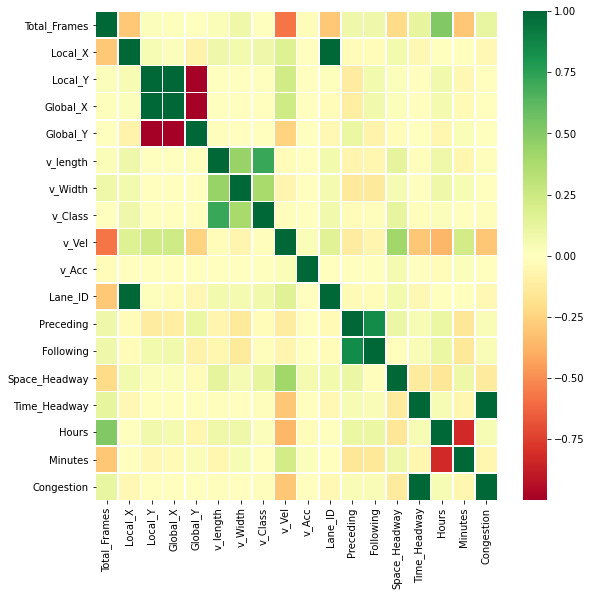

In [26]:
# Heatmap to show the correlation (Pearson's correlation) between the variables
corr = kmeans_df.corr()
plt.figure(figsize=(9,9))
ax = sns.heatmap(corr, linewidth=0.5, cmap='RdYlGn')

In [27]:
kmeans_df['Global_Time'] = global_time

In [28]:
kmeans_df['Time'] = kmeans_df.Global_Time.dt.strftime('%H:%M:%S')

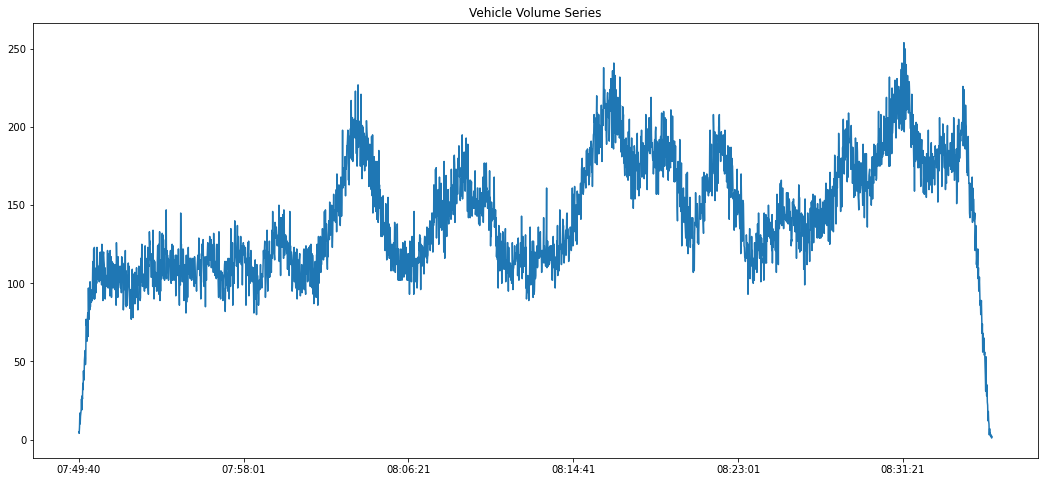

In [29]:
ax = kmeans_df.Time.value_counts().sort_index().plot(kind='line', figsize=(18,8), 
                                              title='Vehicle Volume Series')

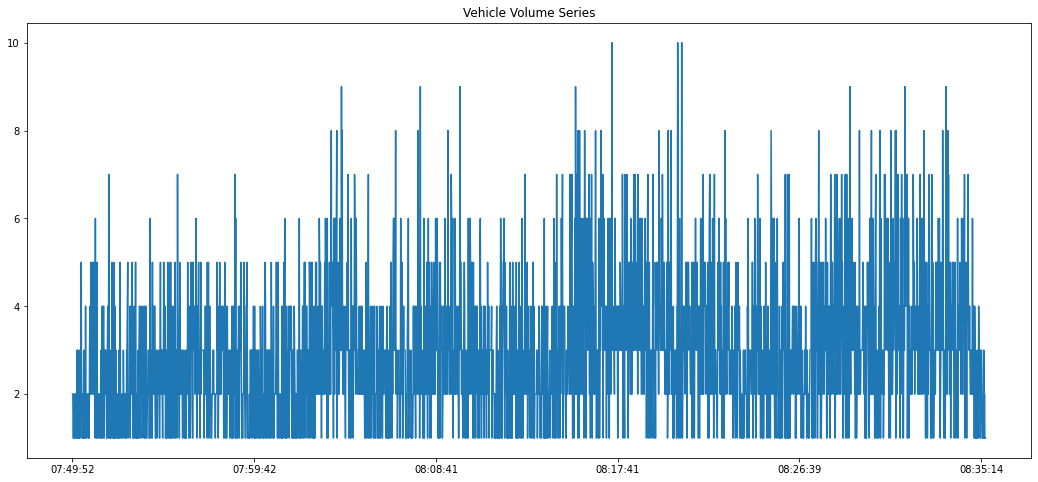

In [30]:
ax = kmeans_df[kmeans_df['Congestion'] == 1].Time.value_counts().sort_index().plot(kind='line', figsize=(18,8), 
                                              title='Vehicle Volume Series')

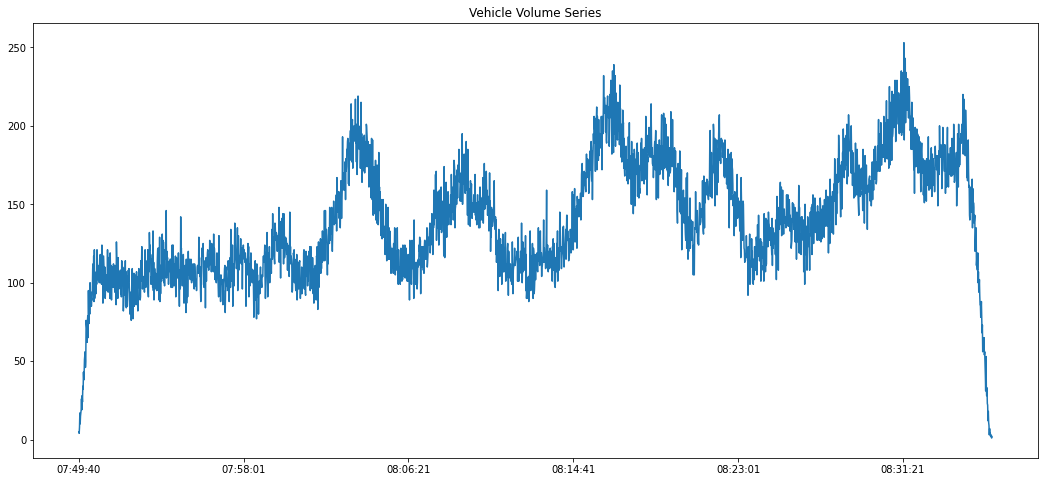

In [31]:
ax = kmeans_df[kmeans_df['Congestion'] == 0].Time.value_counts().sort_index().plot(kind='line', figsize=(18,8), 
                                              title='Vehicle Volume Series')

In [32]:
kmeans_pca_cluster = KMeans(n_clusters=2, random_state=123).fit(pca_cluster)

In [33]:
kmeans_pca_cluster.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [34]:
kmeans_pca_df = data.iloc[:,:]

In [35]:
kmeans_pca_df['Congestion'] = kmeans_pca_cluster.labels_

In [36]:
kmeans_pca_df.head()

,Total_Frames,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway,Hours,Minutes,Congestion,Global_Time,Time
0,1123.0,30.034,188.062,6451203.729,1873252.549,13.0,6.9,2.0,23.31,2.05,3.0,500.0,523.0,119.10,5.11,0.333333,0.116667,0,2005-06-15 08:07:55-07:00,08:07:55
1,567.0,19.632,1775.614,6452425.122,1872172.475,13.5,6.9,2.0,37.52,11.20,2.0,2124.0,2132.0,48.92,1.30,0.333333,0.000000,0,NaT,NaN
2,592.0,6.202,1701.144,6452347.673,1872258.452,13.5,4.4,2.0,41.99,0.10,1.0,1029.0,1040.0,38.81,0.92,0.333333,0.200000,0,2005-06-15 08:00:24.800000-07:00,08:00:24
3,628.0,53.514,817.521,6451655.238,1872800.663,24.0,8.5,3.0,45.12,-0.55,5.0,1882.0,1897.0,102.65,2.27,0.333333,0.566667,0,2005-06-15 08:12:04.700000-07:00,08:12:04
4,996.0,28.878,490.086,6451422.353,1873041.018,15.0,5.9,2.0,24.54,-0.04,3.0,740.0,752.0,37.80,1.54,0.333333,0.150000,0,NaT,NaN


In [37]:
kmeans_pca_df.describe()

,Total_Frames,Local_X,Local_Y,Global_X,Global_Y,v_length,v_Width,v_Class,v_Vel,v_Acc,Lane_ID,Preceding,Following,Space_Headway,Time_Headway,Hours,Minutes,Congestion
count,455846.000000,455846.000000,455846.000000,4.558460e+05,4.558460e+05,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000,455846.000000
mean,739.689195,29.741326,1043.131800,6.451849e+06,1.872668e+06,15.309449,6.296412,2.016080,30.119328,0.159670,2.991453,1272.369618,1276.829528,67.275576,191.713501,0.326388,0.402635,0.018884
std,204.465991,16.588804,603.410021,4.511053e+02,4.008011e+02,4.488224,0.892994,0.162736,14.070791,4.550935,1.459117,815.509491,817.265165,41.049844,1360.754989,0.015529,0.275473,0.136114
min,160.000000,0.369000,3.051000,6.451067e+06,1.871889e+06,4.000000,2.000000,1.000000,0.000000,-11.200000,1.000000,0.000000,0.000000,0.000000,0.000000,0.291667,0.000000,0.000000
25%,568.000000,17.607000,521.866000,6.451455e+06,1.872329e+06,13.500000,5.900000,2.000000,20.000000,-0.770000,2.000000,571.000000,574.000000,43.430000,1.670000,0.333333,0.183333,0.000000
50%,738.000000,29.780000,1003.489500,6.451817e+06,1.872690e+06,15.000000,6.400000,2.000000,30.240000,0.000000,3.000000,1259.000000,1262.000000,59.660000,2.280000,0.333333,0.366667,0.000000
75%,904.000000,41.767750,1553.459000,6.452230e+06,1.873010e+06,16.000000,6.900000,2.000000,39.990000,1.380000,4.000000,1868.000000,1873.000000,82.580000,3.190000,0.333333,0.533333,0.000000
max,1328.000000,75.682000,2217.411000,6.452733e+06,1.873401e+06,76.100000,8.500000,3.000000,95.300000,11.200000,8.000000,3109.000000,3109.000000,771.160000,9999.990000,0.333333,0.983333,1.000000


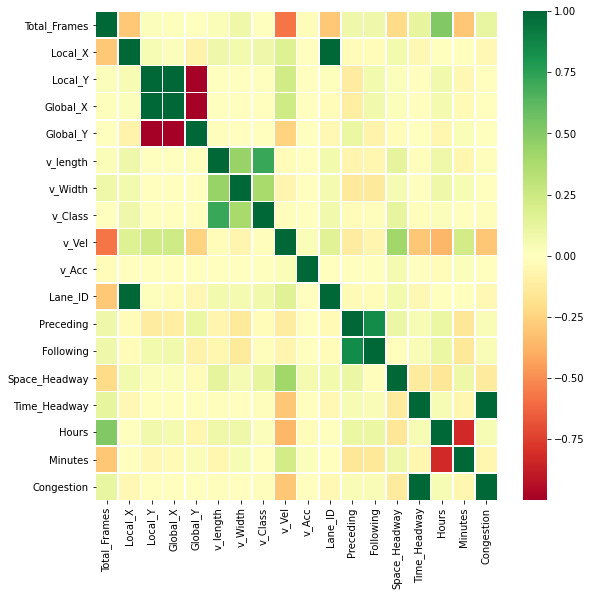

In [38]:
# Heatmap to show the correlation (Pearson's correlation) between the variables
corr = kmeans_pca_df.corr()
plt.figure(figsize=(9,9))
ax = sns.heatmap(corr, linewidth=0.5, cmap='RdYlGn')

In [39]:
kmeans_pca_df['Global_Time'] = global_time

In [40]:
kmeans_pca_df['Time'] = kmeans_pca_df.Global_Time.dt.strftime('%H:%M:%S')

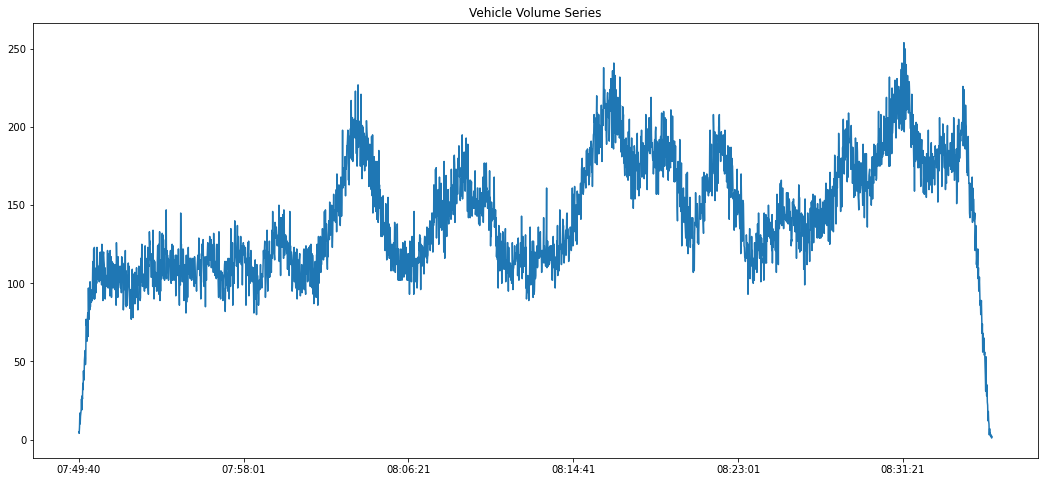

In [41]:
ax = kmeans_pca_df.Time.value_counts().sort_index().plot(kind='line', figsize=(18,8), 
                                              title='Vehicle Volume Series')

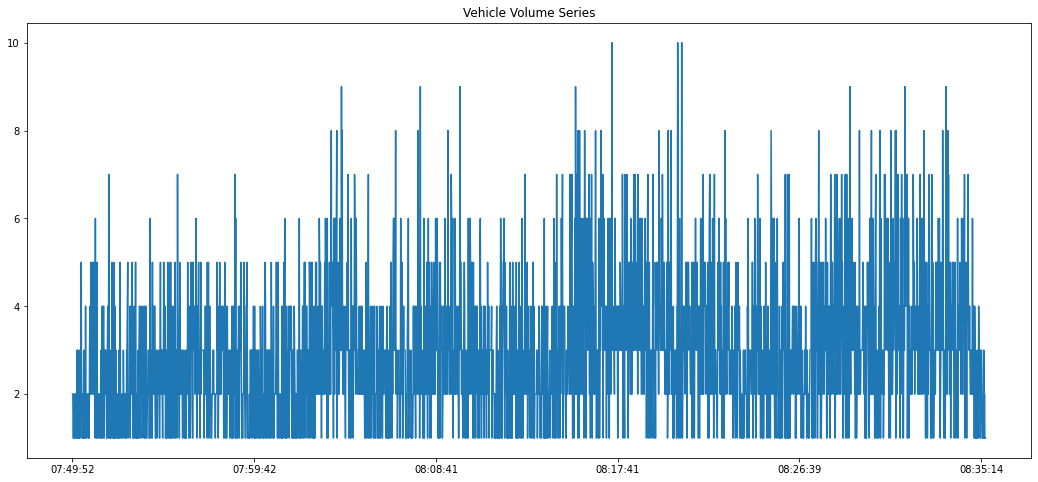

In [42]:
ax = kmeans_pca_df[kmeans_pca_df['Congestion'] == 1].Time.value_counts().sort_index().plot(kind='line', figsize=(18,8), 
                                              title='Vehicle Volume Series')

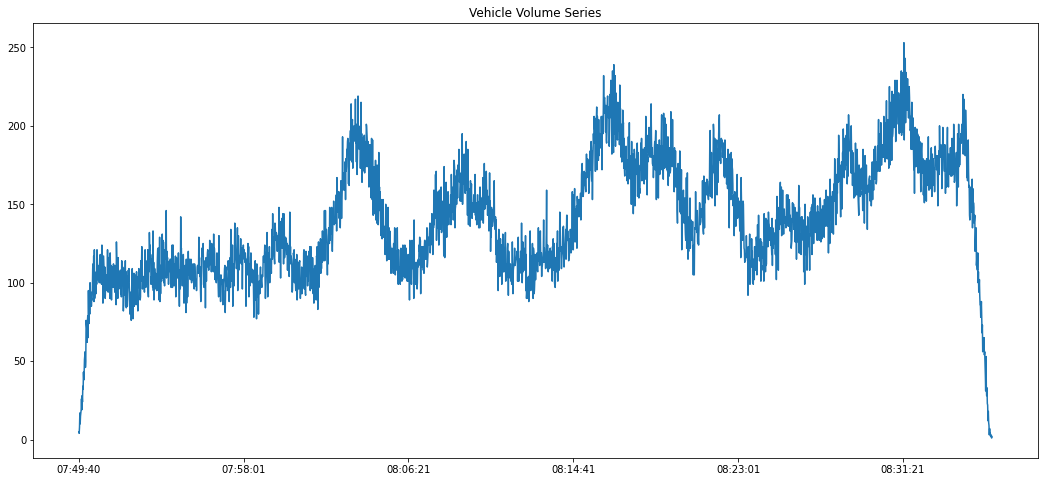

In [43]:
ax = kmeans_pca_df[kmeans_pca_df['Congestion'] == 0].Time.value_counts().sort_index().plot(kind='line', figsize=(18,8), 
                                              title='Vehicle Volume Series')

### Agglometric Hierarchical Clustering

In [ ]:
agglo_cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward').fit(pca_cluster)

In [ ]:
agglo_cluster.labels_

In [ ]:
agglo_df = data.iloc[:,:]